# 2D Linear Elastic Plane-strain Problem

<div class="alert alert-block alert-info">
<b>Note:</b> Problem definition and images are from reference [1]
</div>

See: [Reference](#references)

Problem Description:

An elastic plane-strain problem defined on the unit square.

![Plane Strain](./assets/img/2D_plane_strain.png)

PDE:

$$
\begin{aligned}
\sigma_{ij,j}+f_i &= 0 \\
\sigma_{ij} &= \lambda \delta_{ij} \epsilon_{kk}+2\mu \epsilon_{ij} \\
\epsilon_{ij} &= \frac{1}{2} \left ( u_{i,j} + u_{j,i} \right )
\end{aligned}
$$

Subjected to the following boundary conditions:

$$
\begin{aligned}
f_x &= \lambda \left [ 4 \pi^2 cos(2\pi x)sin(\pi y) - \pi cos(\pi x) Qy^3 \right ] \\
    &+ \mu \left [ 9\pi^2 cos(2\pi x)sin(\pi y) - \pi cos(\pi x)Qy^3 \right ] \\

f_y &= \lambda \left [ -3 sin(\pi x)Qy^2 + 2\pi^2 sin(2\pi x)cos(\pi y) \right ] \\
    &+ \mu \left [ -6 sin(\pi x)Qy^2 +2 \pi^2 sin(2\pi x)cos(\pi y) + \pi^2 sin(\pi x)Qy^4 / 4\right ]
\end{aligned}
$$

Solution: ($\lambda = 1, \mu = 0.5 \space and \space Q = 4$)

$$
\begin{aligned}
u_x(x,y) &= cos(2\pi x)sin(\pi y) \\
u_y(x,y) &= sin(\pi x)Qy^4/4
\end{aligned}
$$

## 1. Import and setup random seeds

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch import pi as pi
from torch import sin as sin
from torch import cos as cos
import matplotlib.pyplot as plt


def set_seeds(seeds):
    torch.manual_seed(seeds)
    torch.cuda.manual_seed(seeds)
    torch.backends.cudnn.deterministic = True

set_seeds(12)

g:\software\Anaconda\envs\yolov5\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Define MLP model

In [2]:
# input x, y, output u_x and u_y
class MLP(nn.Module):
    def __init__(self) -> None:
        super(MLP, self).__init__()
        self.model = torch.nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.model(x)

## 3. Define loss function

In [3]:
# mean square loss
mse_loss = nn.MSELoss()


# gradient
def gradient(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, only_inputs=True)[0]
    else:
        return gradient(gradient(u, x), x, order-1)


def loss_ux_down(model, n, device):
    """
    u_x = 0
    """

    x = torch.rand(n, 1, requires_grad=True, device=device)
    y = torch.zeros_like(x, requires_grad=True, device=device)
    ux = model(torch.cat([x, y], dim=1))[:, 0].view(-1, 1)
    cond = torch.zeros_like(x, requires_grad=True, device=device)
    
    return mse_loss(ux, cond)


def loss_uy_down(model, n, device):
    """
    u_y = 0
    """

    x = torch.rand(n, 1, requires_grad=True, device=device)
    y = torch.zeros_like(x, requires_grad=True, device=device)
    uy = model(torch.cat([x, y], dim=1))[:, 1].view(-1, 1)
    cond = torch.zeros_like(x, requires_grad=True, device=device)
    
    return mse_loss(uy, cond)


def loss_uy_left(model, n, device):
    """
    u_y = 0
    """

    y = torch.rand(n, 1, requires_grad=True, device=device)
    x = torch.zeros_like(y, requires_grad=True, device=device)
    uy = model(torch.cat([x, y], dim=1))[:, 1].view(-1, 1)
    cond = torch.zeros_like(x, requires_grad=True, device=device)
    
    return mse_loss(uy, cond)


def loss_uy_right(model, n, device):
    """
    u_y = 0
    """

    y = torch.rand(n, 1, requires_grad=True, device=device)
    x = torch.ones_like(y, requires_grad=True, device=device)
    uy = model(torch.cat([x, y], dim=1))[:, 1].view(-1, 1)
    cond = torch.zeros_like(x, requires_grad=True, device=device)
    
    return mse_loss(uy, cond)


def loss_ux_up(model, n, device):
    """
    u_x = 0
    """

    x = torch.rand(n, 1, requires_grad=True, device=device)
    y = torch.ones_like(x, requires_grad=True, device=device)
    ux = model(torch.cat([x, y], dim=1))[:, 0].view(-1, 1)

    cond = torch.zeros_like(x, requires_grad=True, device=device)
    
    return mse_loss(ux, cond)


def loss_sxx_left(model, n, device, **kwargs):
    """
    sigma_xx = 0
    """

    la = kwargs.get("la")
    mu = kwargs.get("mu")

    y = torch.rand(n, 1, requires_grad=True, device=device)
    x = torch.zeros_like(y, requires_grad=True, device=device)
    ux = model(torch.cat([x, y], dim=1))[:, 0].view(-1, 1)
    uy = model(torch.cat([x, y], dim=1))[:, 1].view(-1, 1)

    exx = gradient(ux, x, 1) # epsilon xx
    eyy = gradient(uy, y, 1) # epsilon yy
    sxx = 2 * mu * exx + la * (exx + eyy)

    cond = torch.zeros_like(x, requires_grad=True, device=device)
    
    return mse_loss(sxx, cond)


def loss_sxx_right(model, n, device, **kwargs):
    """
    sigma_xx = 0
    """
    la = kwargs.get("la")
    mu = kwargs.get("mu")

    y = torch.rand(n, 1, requires_grad=True, device=device)
    x = torch.ones_like(y, requires_grad=True, device=device)
    ux = model(torch.cat([x, y], dim=1))[:, 0].view(-1, 1)
    uy = model(torch.cat([x, y], dim=1))[:, 1].view(-1, 1)

    exx = gradient(ux, x, 1) # epsilon xx
    eyy = gradient(uy, y, 1) # epsilon yy
    sxx = 2 * mu * exx + la * (exx + eyy)

    cond = torch.zeros_like(x, requires_grad=True, device=device)
    
    return mse_loss(sxx, cond)


def loss_syy_up(model, n, device, **kwargs):
    """
    sigma_yy = 0
    """

    la = kwargs.get("la")
    mu = kwargs.get("mu")
    q = kwargs.get("q")

    x = torch.rand(n, 1, requires_grad=True, device=device)
    y = torch.ones_like(x, requires_grad=True, device=device)
    ux = model(torch.cat([x, y], dim=1))[:, 0].view(-1, 1)
    uy = model(torch.cat([x, y], dim=1))[:, 1].view(-1, 1)

    exx = gradient(ux, x, 1) # epsilon xx
    eyy = gradient(uy, y, 1) # epsilon yy
    syy = 2 * mu * eyy + la * (exx + eyy)

    cond = (la + 2 * mu) * q * sin(pi * x)
    
    return mse_loss(syy, cond)


def loss_fx(model, n, device, **kwargs):
    """
    body force x
    """

    la = kwargs.get("la")
    mu = kwargs.get("mu")
    q = kwargs.get("q")

    x = torch.rand(n, 1, requires_grad=True, device=device)
    y = torch.rand(n, 1, requires_grad=True, device=device)
    ux = model(torch.cat([x, y], dim=1))[:, 0].view(-1, 1)
    uy = model(torch.cat([x, y], dim=1))[:, 1].view(-1, 1)

    exx = gradient(ux, x, 1) # epsilon xx
    exy = 0.5 * (gradient(ux, y, 1) + gradient(uy, x, 1))
    eyy = gradient(uy, y, 1) # epsilon yy
    sxx = 2 * mu * exx + la * (exx + eyy)
    sxy = 2 * mu * exy
    syy = 2 * mu * eyy + la * (exx + eyy)

    fx = -(gradient(sxx, x, 1) + gradient(sxy, y, 1))

    cond = la * (4 * pi**2 * cos(2*pi*x) * sin(pi*y) - \
                 pi * cos(pi*x) * q * y**3) + \
                 mu * (9 * pi**2 * cos(2*pi*x) * sin(pi*y) - \
                 pi * cos(pi*x) * q * y**3)
    
    return mse_loss(fx, cond)


def loss_fy(model, n, device, **kwargs):
    """
    body force y
    """

    la = kwargs.get("la")
    mu = kwargs.get("mu")
    q = kwargs.get("q")

    x = torch.rand(n, 1, requires_grad=True, device=device)
    y = torch.rand(n, 1, requires_grad=True, device=device)
    ux = model(torch.cat([x, y], dim=1))[:, 0].view(-1, 1)
    uy = model(torch.cat([x, y], dim=1))[:, 1].view(-1, 1)

    exx = gradient(ux, x, 1) # epsilon xx
    exy = 0.5 * (gradient(ux, y, 1) + gradient(uy, x, 1))
    eyy = gradient(uy, y, 1) # epsilon yy
    sxx = 2 * mu * exx + la * (exx + eyy)
    sxy = 2 * mu * exy
    syy = 2 * mu * eyy + la * (exx + eyy)

    fy = -(gradient(syy, y, 1) + gradient(sxy, x, 1))

    cond = la * (-3 * sin(pi*x) * q * y**2 + \
                 2 * pi**2 * sin(2*pi*x) * cos(pi*y)) + \
                 mu * (-6 * sin(pi*x) * q * y**2 + \
                 2 * pi**2 * sin(2*pi*x) * cos(pi*y) + \
                 pi**2 * sin(pi*x) * q * y**4 / 4)
    
    return mse_loss(fy, cond)

## 4. Training

In [9]:
# set training parameters
num_epochs = 20000
device = "cuda:0" if torch.cuda.is_available() else "cpu"

n_pde = 1000 # sampling nunber

la = 1
mu = 0.5
q = 4

# record loss
loss_list = []
best_loss = 1.0E10

# training
model = MLP().to(device=device)
optimizer = torch.optim.Adam(params=model.parameters())

for epoch in range(num_epochs):
    optimizer.zero_grad()

    l00 = loss_ux_down(model, n_pde, device)
    l01 = loss_uy_down(model, n_pde, device)
    l02 = loss_uy_left(model, n_pde, device)
    l03 = loss_uy_right(model, n_pde, device)
    l04 = loss_ux_up(model, n_pde, device)
    l05 = loss_sxx_left(model, n_pde, device, la=la, mu=mu, q=q)
    l06 = loss_sxx_right(model, n_pde, device, la=la, mu=mu, q=q)
    l07 = loss_syy_up(model, n_pde, device, la=la, mu=mu, q=q)
    l08 = 0.01 * loss_fx(model, n_pde, device, la=la, mu=mu, q=q)
    l09 = 0.01 * loss_fy(model, n_pde, device, la=la, mu=mu, q=q)

    loss =  l00 + l01 + l02 + l03 + l04 + l05 + l06 + l07 + l08 + l09

    loss.backward()
    
    optimizer.step()

    if epoch % 100 == 0:
        # print("Epoch: ", epoch, " loss: ", loss.item())
        print("Epoch: ", epoch, end="\t")
        print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}".format(\
              l00.item(), l01.item(), l02.item(), l03.item(), l04.item(), l05.item(),
              l06.item(), l07.item(), l08.item(), l09.item(), loss.item()), sep='\t')

    # save model
    loss_list.append(loss.item()) # record loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), "./assets/plane_strain_linear_elastic_best.pth")


Epoch:  0	0.0175 0.0001 0.0001 0.0004 0.0225 0.0038 0.0005 31.4940 18.2943 2.4732 52.3065
Epoch:  100	0.1219 0.0230 0.7143 0.0144 0.1105 0.4549 0.0172 0.8637 18.0843 3.8896 24.2936
Epoch:  200	0.0042 0.0004 0.0957 0.0004 0.1114 0.0450 0.0742 0.4502 18.5796 3.1695 22.5306
Epoch:  300	0.0020 0.0003 0.0269 0.0023 0.0378 0.0290 0.0362 0.3200 16.8270 2.6450 19.9265
Epoch:  400	0.0002 0.0016 0.0145 0.0049 0.0364 0.0438 0.0334 0.2495 17.7591 2.3902 20.5335
Epoch:  500	0.0289 0.0075 0.0150 0.0698 0.2614 0.0568 0.1599 0.2744 13.0484 2.2964 16.2184
Epoch:  600	0.0393 0.0055 0.0023 0.0009 0.0372 0.0142 0.0167 0.0261 0.5581 0.2246 0.9249
Epoch:  700	0.0143 0.0095 0.0017 0.0043 0.0117 0.0081 0.0116 0.0121 0.1644 0.0760 0.3138
Epoch:  800	0.0098 0.0079 0.0014 0.0024 0.0071 0.0043 0.0119 0.0068 0.1018 0.0571 0.2104
Epoch:  900	0.0073 0.0060 0.0009 0.0019 0.0058 0.0046 0.0169 0.0065 0.0625 0.0433 0.1556
Epoch:  1000	0.0060 0.0042 0.0006 0.0011 0.0053 0.0044 0.0055 0.0044 0.0385 0.0308 0.1008
Epoch:  1

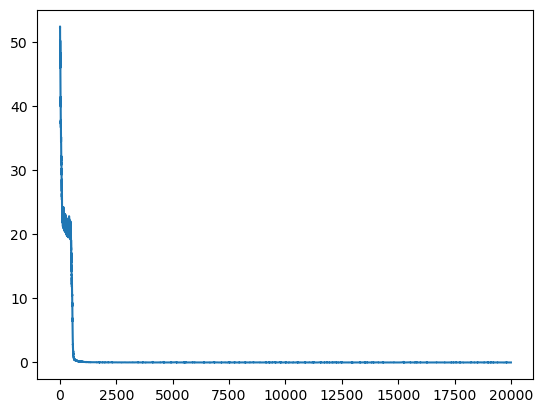

In [10]:
# plot loss
plt.plot(np.array(loss_list))

## 5. Inference and visualization

In [38]:
# material properties
la = 1
mu = 0.5
q = 4

# mesh
n_mesh = 101 # 画图网格密度

xc = torch.linspace(0, 1, n_mesh)
xm, ym = torch.meshgrid(xc, xc)

xm.requires_grad = True
ym.requires_grad = True

# real
ux_real = cos(2*pi*xm) * sin(pi*ym)
uy_real = sin(pi*xm) * q * ym**4 / 4

exx_real = gradient(ux_real, xm, 1) # epsilon xx
exy_real = 0.5 * (gradient(ux_real, ym, 1) + gradient(uy_real, xm, 1)) # epsilon xy
eyy_real = gradient(uy_real, ym, 1) # epsilon yy

sxx_real = 2 * mu * exx_real + la * (exx_real + eyy_real) # sigma xx
sxy_real = 2 * mu * exy_real # sigma xy
syy_real = 2 * mu * eyy_real + la * (exx_real + eyy_real) # sigma yy

# load model
model = MLP()
model.load_state_dict(torch.load("./assets/plane_strain_linear_elastic_best.pth"))

# prediction & error
xx = xm.reshape(-1, 1)
yy = ym.reshape(-1, 1)
xy = torch.cat([xx, yy], dim=1)

ux_pred = model(xy)[:, 0].reshape(xm.shape)
ux_error = torch.abs(ux_pred - ux_real)

uy_pred = model(xy)[:, 1].reshape(ym.shape)
uy_error = torch.abs(uy_pred - uy_real)

exx_pred = gradient(ux_pred, xx, 1).reshape(xm.shape)
exx_error = torch.abs(exx_pred - exx_real)

exy_pred = (0.5 * (gradient(ux_pred, yy, 1) + gradient(uy_pred, xx, 1))).reshape(xm.shape)
exy_error = torch.abs(exy_pred - exy_real)

eyy_pred = gradient(uy_pred, yy, 1).reshape(xm.shape)
eyy_error = torch.abs(eyy_pred - eyy_real)

sxx_pred = (2 * mu * exx_pred + la * (exx_pred + eyy_pred)).reshape(xm.shape)
sxx_error = torch.abs(sxx_pred - sxx_real)

sxy_pred = (2 * mu * exy_pred).reshape(xm.shape)
sxy_error = torch.abs(sxy_pred - sxy_real)

syy_pred = (2 * mu * eyy_pred + la * (exx_pred + eyy_pred)).reshape(xm.shape)
syy_error = torch.abs(syy_pred - syy_real)

# plot
xm = xm.detach().numpy()
ym = ym.detach().numpy()

ux_real = ux_real.detach().numpy()
ux_pred = ux_pred.detach().numpy()
ux_error = ux_error.detach().numpy()

uy_real = uy_real.detach().numpy()
uy_pred = uy_pred.detach().numpy()
uy_error = uy_error.detach().numpy()

exx_real = exx_real.detach().numpy()
exx_pred = exx_pred.detach().numpy()
exx_error = exx_error.detach().numpy()

exy_real = exy_real.detach().numpy()
exy_pred = exy_pred.detach().numpy()
exy_error = exy_error.detach().numpy()

eyy_real = eyy_real.detach().numpy()
eyy_pred = eyy_pred.detach().numpy()
eyy_error = eyy_error.detach().numpy()

sxx_real = sxx_real.detach().numpy()
sxx_pred = sxx_pred.detach().numpy()
sxx_error = sxx_error.detach().numpy()

sxy_real = sxy_real.detach().numpy()
sxy_pred = sxy_pred.detach().numpy()
sxy_error = sxy_error.detach().numpy()

syy_real = syy_real.detach().numpy()
syy_pred = syy_pred.detach().numpy()
syy_error = syy_error.detach().numpy()


In [29]:
def my_subplot(x, y, *data):
    """
    len(data) == 3
    """

    assert(len(data) == 3)

    fig, axes = plt.subplots(1, 3, figsize=(15, 3.5))
    label_list = ["Pred", "Real", "Error"]

    for i in range(3):
        # plt.pcolormesh(xm, ym, ux_real, cmap=plt.cm.rainbow)
        # plt.pcolormesh(xm, ym, ux_real, cmap="RdBu_r", zorder=1)
        # plt.contour(xm, ym, ux_real, 50, cmap="RdBu_r", zorder=1)
        im = axes[i].pcolormesh(x, y, data[i], cmap=plt.cm.rainbow)
        axes[i].text(0.5, 0.9, label_list[i], transform=axes[i].transAxes)
        fig.colorbar(im, ax=axes[i])

    plt.show()

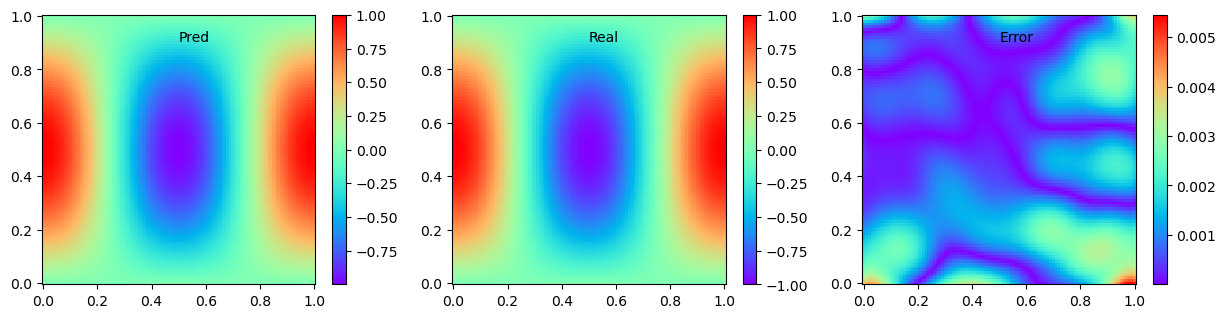

In [30]:
# ux
my_subplot(xm, ym, ux_pred, ux_real, ux_error)

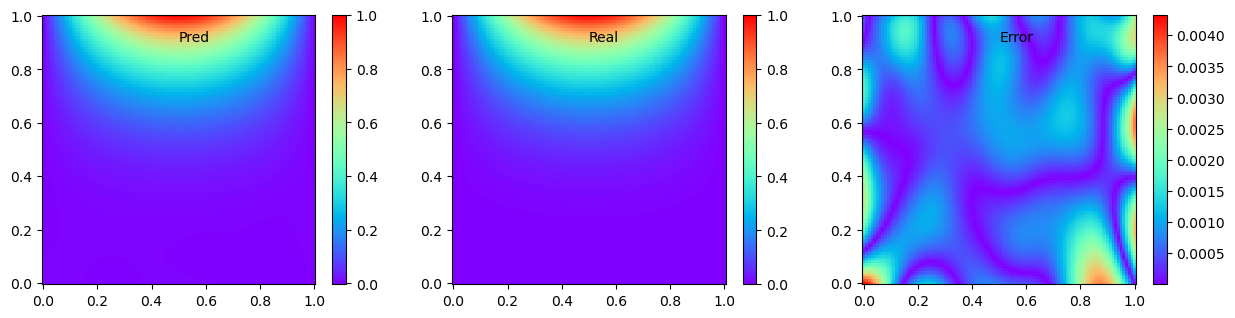

In [31]:
# uy
my_subplot(xm, ym, uy_pred, uy_real, uy_error)

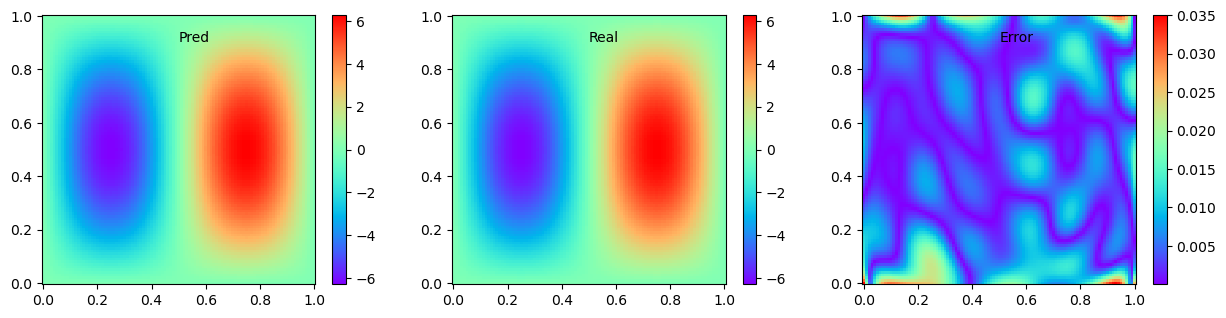

In [32]:
# exx
my_subplot(xm, ym, exx_pred, exx_real, exx_error)

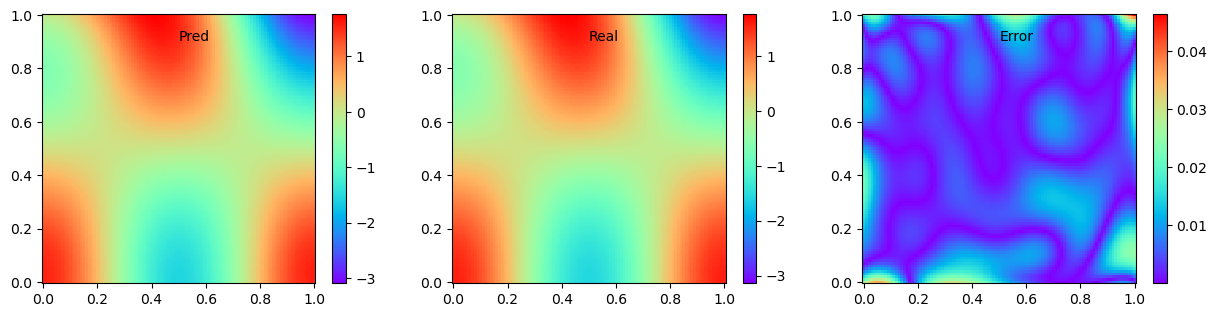

In [39]:
# exy
my_subplot(xm, ym, exy_pred, exy_real, exy_error)

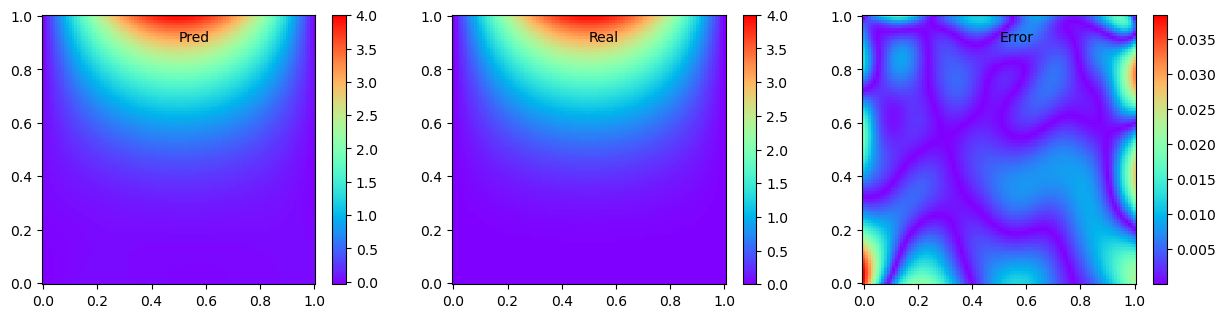

In [40]:
# eyy
my_subplot(xm, ym, eyy_pred, eyy_real, eyy_error)

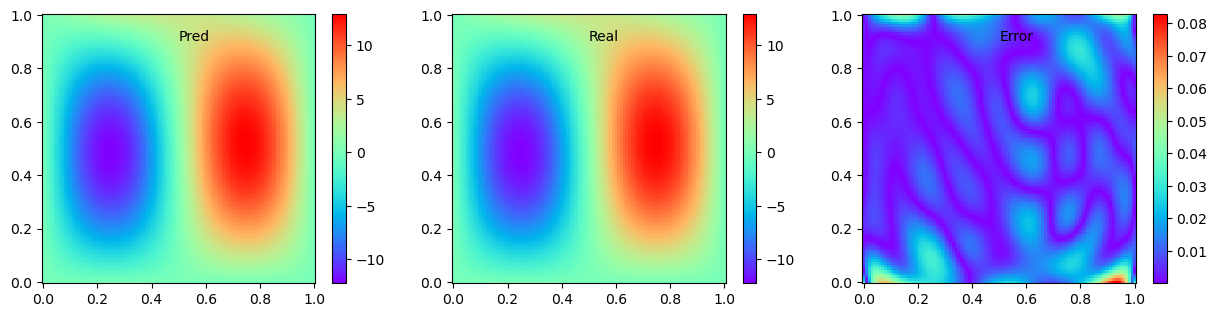

In [42]:
# sxx
my_subplot(xm, ym, sxx_pred, sxx_real, sxx_error)

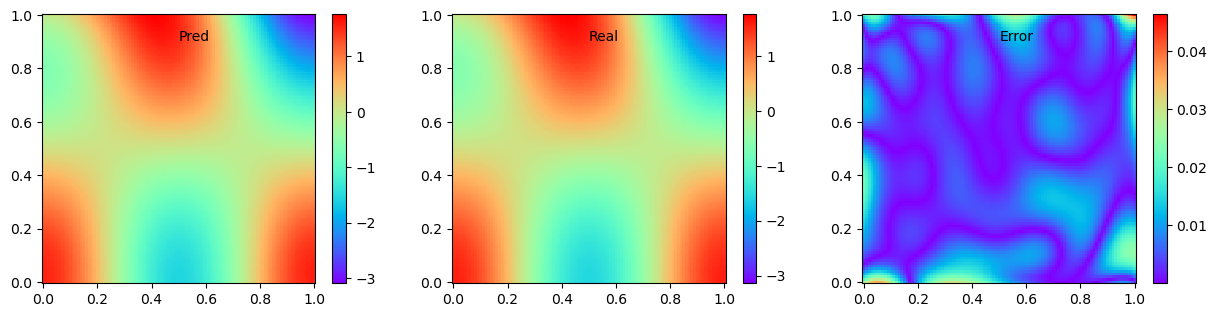

In [36]:
# sxy
my_subplot(xm, ym, sxy_pred, sxy_real, sxy_error)

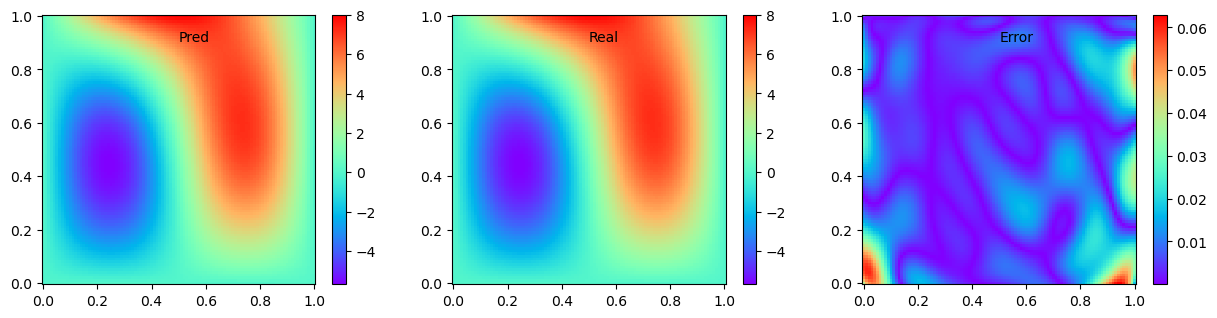

In [44]:
# syy
my_subplot(xm, ym, syy_pred, syy_real, syy_error)

## References

[1] E. Haghighat, M. Raissi, A. Moure, H. Gomez, R. Juanes, A deep learning framework for solution and discovery in solid mechanics, (2020). http://arxiv.org/abs/2003.02751 (accessed June 25, 2023).
